In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from time import sleep
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('all_years_data.csv')
dbase = pd.read_csv('all_runs_scored.csv')
tempSeries = dbase['Runs']
tempSeries = dbase['Runs'].sort_values(inplace=0)
len(tempSeries)

37830

In [3]:
headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'Custom User Agent 1.0',
        'From': 'nsrivast@iitk.ac.in'  # Stick in your IITK email id
    }
)

In [4]:
scores = []
salience_list = [0]*(len(df)-1)
outcome = [0]*(len(df)-1)

In [6]:
for row in range(1000,len(df)-1):
    url = df[row-1:row].url.item()
    team_1 = df[row-1:row].Team_1.item()
    team_2 = df[row-1:row].Team_2.item()
    winner = df[row-1:row].Winner.item()
    sleep(int(np.random.normal(3,0.2)*100)/(100*1.0))
    print(row)
    proxyDict = { 
              "http"  : "http://ironport2.iitk.ac.in:3128", 
              "https" : "http://ironport2.iitk.ac.in:3128"
            }
    r = requests.get(url, headers=headers, proxies=proxyDict, verify=False)
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find_all(class_='batting-table innings')
    
    lst = []
    key = []
    
    ts = [[], [], [], []]
    salience = [[], [], [], []]
    for innings in range(len(table)):
        for string in table[innings](class_='th-innings-heading')[0].strings:
            lst.append(str(string))
        key.append(lst[0].strip().replace(' 1st innings', '').replace(' 2nd innings', ''))

        for batsman in table[innings]('tr', class_=''):                
            if batsman.find(class_='bold').string.isdigit():                
                ts[innings].append(int(batsman.find(class_='bold').string))                
                salience[innings].append(len(tempSeries)/(tempSeries >= int(batsman.find(class_='bold').string)).sum())        
        lst = []    
    scores.append(ts)
    t1_idx = [i for i, x in enumerate(key) if x == df[row-1:row].Team_1.values[0]]
    t2_idx = [i for i, x in enumerate(key) if x == df[row-1:row].Team_2.values[0]]
    if(len(t1_idx)==2):        
        t1 = salience[t1_idx[0]] + salience[t1_idx[1]]
    elif(len(t1_idx)==1):        
        t1 = salience[t1_idx[0]]
    else:
        t1 = [0]
    if(len(t2_idx)==2):        
        t2 = salience[t2_idx[0]] + salience[t2_idx[1]]
    elif(len(t2_idx)==1):        
        t2 = salience[t2_idx[0]]        
    else:
        t2 = [0]
    t1.sort(reverse=1)
    t2.sort(reverse=1)
    salience_list[row] = np.sum(t1[0:3]) - np.sum(t2[0:3])
    if (winner==team_1):
        outcome[row] = 1
    elif(winner==team_2):
        outcome[row] = -1
    else:
        outcome[row] = 0

1000


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:794: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


1001
1002
1003


KeyboardInterrupt: 

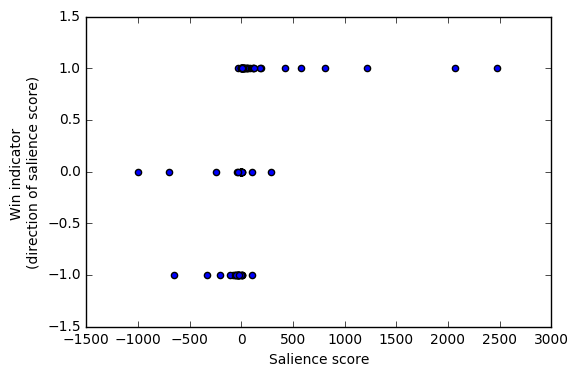

In [37]:
plt.scatter(salience_list, outcome)
plt.xlabel('Salience score')
plt.ylabel('Win indicator \n(direction of salience score)')
plt.show()

In [38]:
results = {'Salience': salience_list, 'Outcome': outcome}
resdf = pd.DataFrame(results)

In [39]:
resdf['Predictor'] = (resdf['Salience']>0)*1

In [40]:
from scipy.stats import pearsonr
pearsonr(resdf['Outcome'], resdf['Predictor']) # a decent correlation between the outcome and the predictor

(0.59488791809751562, 9.5674807519140152e-103)

In [41]:
resdf['intercept'] = 1.0

In [42]:
resdf.Outcome[resdf['Outcome']==-1] = 0 # treating draws as losses for the home team. YMMV.

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
logit = sm.Logit(resdf['Outcome'], resdf[['Salience', 'intercept']])
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.099502
         Iterations 9


In [45]:
print(logit_result.summary()) # logistic regression with the original salience score gives terrible results. Why?

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                 1063
Model:                          Logit   Df Residuals:                     1061
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Jan 2017   Pseudo R-squ.:                  0.3127
Time:                        16:21:09   Log-Likelihood:                -105.77
converged:                       True   LL-Null:                       -153.89
                                        LLR p-value:                 1.018e-22
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Salience       0.0485      0.009      5.493      0.000         0.031     0.066
intercept     -3.9092      0.223    -17.509      0.000        -4.347    -3.472
